# Requesting Argo data from Ifremer erddap, expert mode

Using the expert mode, you can have access to all fields retrieved from the erddap, including all QC variables and without any data mode filtering.

***
Script prepared by [Guillaume Maze](http://github.com/gmaze) (Mar. 2020)

This work is part and was supported by the following projects:
<div>
<img src="https://avatars1.githubusercontent.com/u/58258213?s=460&v=4" width="70"/>
<img src="http://www.argo-france.fr/wp-content/uploads/2019/10/Argo-logo_banner-color.png" width="200"/>
<img src="https://www.umr-lops.fr/var/storage/images/_aliases/logo_main/medias-ifremer/medias-lops/logos/logo-lops-2/1459683-4-fre-FR/Logo-LOPS-2.png" width="70"/>
</div>

In [1]:
import sys, os
import numpy as np
import xarray as xr

# Not definitive access to the end-user API:
sys.path.insert(0, os.path.abspath('..'))
from fetchers import ArgoDataFetcher

#
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import cmocean
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

# Usefull colormaps and colorbar makers:
qcmap = mpl.colors.ListedColormap(['#000000', 
                                   '#31FC03', 
                                   '#ADFC03', 
                                   '#FCBA03', 
                                   '#FC1C03',
                                   '#324CA8', 
                                   '#000000', 
                                   '#000000', 
                                   '#B22CC9', 
                                   '#000000'])
def colorbar_qc(cmap, **kwargs):
    """Adjust colorbar ticks with discrete colors for QC flags"""
    ncolors = 10
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    return colorbar

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['A','D','R'])

dmode_map = mpl.colors.ListedColormap(['#FCBA03','#31FC03','#FF0000'])
def colorbar_dmode(cmap=dmode_map, **kwargs):
    """Adjust colorbar ticks with discrete colors for DATA MODE"""
    ncolors = 3
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(le.classes_)
    return colorbar

# Create the Argo data loader instance

If we want to retrieve data without post-processing, we need to specify the ``mode`` option to ``expert`` when creating the data loader instance.

In [2]:
argo_loader = ArgoDataFetcher(mode='expert', cache=1, cachedir='tmp')
argo_loader

<datafetcher 'Not initialised'>
User mode: expert

# Example of data fetching for a specific region

In [3]:
box = [-80., 0., 26-0.5, 26+.5, 0, 1000, '2018-01-01','2018-12-31']
argo = argo_loader.region(box).to_xarray()
argo

<xarray.Dataset>
Dimensions:              (index: 84912)
Coordinates:
    time                 (index) datetime64[ns] ...
  * index                (index) int64 0 1 2 3 4 ... 84908 84909 84910 84911
    longitude            (index) float64 ...
    latitude             (index) float64 ...
Data variables:
    CYCLE_NUMBER         (index) int64 ...
    DATA_MODE            (index) <U1 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D' 'D'
    DIRECTION            (index) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER      (index) int64 ...
    POSITION_QC          (index) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PRES                 (index) float64 ...
    PRES_ADJUSTED        (index) float64 ...
    PRES_ADJUSTED_ERROR  (index) float64 ...
    PRES_ADJUSTED_QC     (index) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PRES_QC              (index) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PSAL                 (index) float64 ...
    PSAL_ADJUSTED        (index) float64 ...
    PSAL_ADJUSTED_ERROR  (index) float64 ...
    PSAL_ADJUSTED_QC     (index) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PSAL_QC              (index) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    TEMP                 (index) float64 ...
    TEMP_ADJUSTED        (index) float64 ...
    TEMP_ADJUSTED_ERROR  (index) float64 ...
    TEMP_ADJUSTED_QC     (index) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    TEMP_QC              (index) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    TIME_QC              (index) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:               ARGO
    DOI:                   http://doi.org/10.17882/42182
    Downloaded_from:       http://www.ifremer.fr/erddap
    Downloaded_by:         gmaze
    Download_date:         2020/03/03
    Download_url:          http://www.ifremer.fr/erddap/tabledap/ArgoFloats.c...
    Download_constraints:  phy_[x=-80.00/0.00; y=25.50/26.50; z=0.0/1000.0; t...
    cache:                 tmp/TSargo_phy_28000_00000_02550_02650_00000_10000...

## QC figure with unfiltered data

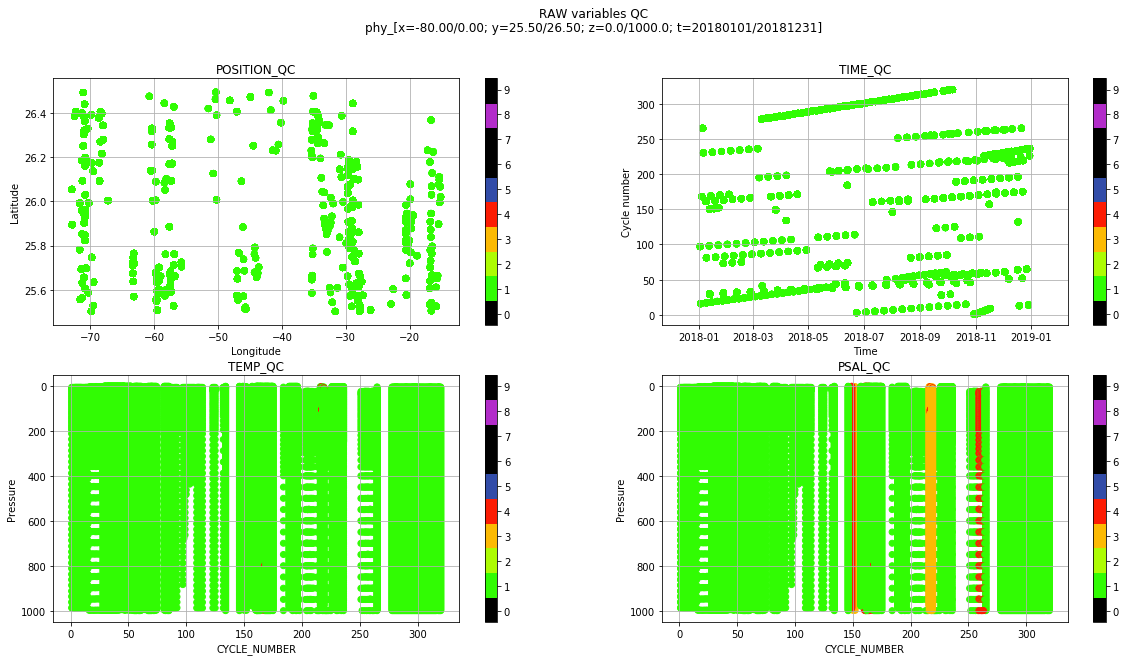

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo['longitude'], argo['latitude'], c=argo['POSITION_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Longitude')
ax[ix].set_ylabel('Latitude')
ax[ix].set_title('POSITION_QC')

ix += 1
sc = ax[ix].scatter(argo['time'].values, argo['CYCLE_NUMBER'], c=argo['TIME_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Time')
ax[ix].set_ylabel('Cycle number')
ax[ix].set_title('TIME_QC')

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['TEMP_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('TEMP_QC')

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['PSAL_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('PSAL_QC')

fig.suptitle("RAW variables QC\n%s" % argo.attrs['Download_constraints']);

# Filter data according to data mode

But this is (nearly) the raw output of the request. It could be useful to simply select the most appropriate variables according to the data mode (Real time, adjusted and delayed mode). 

Note that this is done automatically in ``mode='standard'``.

KeyError: 'convention'

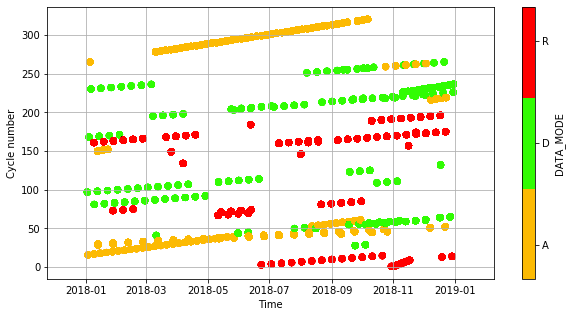

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax = np.array(ax).flatten()
sc = ax[0].scatter(argo['time'].values, argo['CYCLE_NUMBER'], c=le.transform(argo['DATA_MODE']), 
            vmin=0, vmax=2, cmap=dmode_map)
colorbar_dmode(label='DATA_MODE', ax=ax[0])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Cycle number')
ax[0].grid()
ax[0].set_title(argo['DATA_MODE'].attrs['convention']);

## Filter data according to data mode

In [ ]:
argo_filtered = argo_loader.region(box).fetcher.filter_data_mode(argo)

## QC figure with appropriate variables

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo_filtered['longitude'], argo_filtered['latitude'], c=argo_filtered['POSITION_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Longitude')
ax[ix].set_ylabel('Latitude')
ax[ix].set_title('POSITION_QC')

ix += 1
sc = ax[ix].scatter(argo_filtered['time'].values, argo_filtered['CYCLE_NUMBER'], c=argo_filtered['TIME_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Time')
ax[ix].set_ylabel('Cycle number')
ax[ix].set_title('TIME_QC')

ix += 1
sc = ax[ix].scatter(argo_filtered['CYCLE_NUMBER'], argo_filtered['PRES'], c=argo_filtered['TEMP_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('TEMP_QC')

ix += 1
sc = ax[ix].scatter(argo_filtered['CYCLE_NUMBER'], argo_filtered['PRES'], c=argo_filtered['PSAL_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('PSAL_QC')

fig.suptitle("QC flags of Data mode filtered variables\n%s" % argo.attrs['Download_constraints']);

# Example of data fetching for a specific float

In [ ]:
float_fetcher = argo_loader.float(6902746)
# float_fetcher = argo_loader.float(2903005) # Float with RBRargo sensor

argo_unfiltered = float_fetcher.to_xarray()
argo = float_fetcher.fetcher.filter_data_mode(argo_unfiltered)
argo

In [ ]:
# Get basic information about the float:
print('This float has performed: %i profiles' % len(np.unique(argo['CYCLE_NUMBER'])))
print('This float operated between %s and %s' % (argo['time'].min().values, argo['time'].max().values))
print('This float profiles range from %0.1fdb to %0.1fdb' % (argo['PRES'].min(), argo['PRES'].max() ))

## Plot trajectory

In [ ]:
this = argo.reset_coords().groupby('CYCLE_NUMBER').min()
plt.plot(this['longitude'], this['latitude'], '-', color=[0.7]*3, zorder=0)
plt.scatter(this['longitude'], this['latitude'], c=this['CYCLE_NUMBER'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gca().grid()
plt.colorbar(label='CYCLE_NUMBER')
plt.title(argo.attrs['Download_constraints'])
plt.show()

## QC flags for appropriate variables

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = np.array(ax).flatten()

ix = 0
ax[ix].plot(argo['longitude'], argo['latitude'], '-', color=[0.7]*3, zorder=0)
sc = ax[ix].scatter(argo['longitude'], argo['latitude'], c=argo['POSITION_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Longitude')
ax[ix].set_ylabel('Latitude')
ax[ix].set_title('POSITION_QC')

ix += 1
sc = ax[ix].scatter(argo['time'].values, argo['CYCLE_NUMBER'], c=argo['TIME_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Time')
ax[ix].set_ylabel('Cycle number')
ax[ix].set_title('TIME_QC')

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['TEMP_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('TEMP_QC')

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['PSAL_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('PSAL_QC')

fig.suptitle("Data mode filtered variables QC\n%s" % argo.attrs['Download_constraints']);

## DATA MODE

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax = np.array(ax).flatten()
sc = ax[0].scatter(argo['time'].values, argo['CYCLE_NUMBER'], c=le.transform(argo['DATA_MODE']), 
            vmin=0, vmax=2, cmap=dmode_map)
colorbar_dmode(label='DATA_MODE', ax=ax[0])
ax[0].set_ylabel('CYCLE_NUMBER')
ax[0].set_xlabel('TIME')
ax[0].grid()
ax[0].set_title(argo['DATA_MODE'].attrs['convention']);

## Hovmoller

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,10), sharex=True, sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['TEMP'], cmap=cmocean.cm.thermal)
plt.colorbar(sc, ax=ax[ix], label=argo['TEMP'].attrs['units'])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['PSAL'], cmap=cmocean.cm.haline)
plt.colorbar(sc, ax=ax[ix], label=argo['PSAL'].attrs['units'])
ax[ix].grid()
# ax[ix].invert_yaxis()
ax[ix].set_xlabel(argo['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['PSAL'].attrs['long_name']);

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10), sharex=True, sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['TEMP'], cmap=cmocean.cm.thermal)
plt.colorbar(sc, ax=ax[ix], label=argo['TEMP'].attrs['units'])
ax[ix].invert_yaxis()
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['TEMP_ERROR'], cmap=cmocean.cm.amp)
plt.colorbar(sc, ax=ax[ix], label=argo['TEMP_ERROR'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['TEMP_ERROR'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['PSAL'], cmap=cmocean.cm.haline)
plt.colorbar(sc, ax=ax[ix], label=argo['PSAL'].attrs['units'])
ax[ix].set_xlabel(argo['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['PSAL'].attrs['long_name']);

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['PSAL_ERROR'], cmap=cmocean.cm.amp)
plt.colorbar(sc, ax=ax[ix], label=argo['PSAL_ERROR'].attrs['units'])
ax[ix].set_xlabel(argo['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['PSAL_ERROR'].attrs['long_name']);

## Super-imposed profiles

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo['TEMP'], argo['PRES'], c=argo['CYCLE_NUMBER'])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel(argo['TEMP'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo['PSAL'], argo['PRES'], c=argo['CYCLE_NUMBER'])
plt.colorbar(sc, ax=ax[ix], label=argo['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].grid()
ax[ix].set_xlabel(argo['PSAL'].attrs['units'])
ax[ix].set_title(argo['PSAL'].attrs['long_name']);


## T/S diagram

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
ax = np.array(ax).flatten()
ix = 0
sc = ax[ix].scatter(argo['PSAL'], argo['TEMP'], c=argo['CYCLE_NUMBER'])
ax[ix].grid()
ax[ix].set_xlabel("%s [%s]" % (argo['PSAL'].attrs['long_name'], argo['PSAL'].attrs['units']))
ax[ix].set_ylabel("%s [%s]" % (argo['TEMP'].attrs['long_name'], argo['TEMP'].attrs['units']))
plt.title(argo.attrs['Download_constraints']);

# Filter data according to QC flags

In [ ]:
argo_ok = float_fetcher.fetcher.filter_qc(argo)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10), sharex=True, sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo_ok['CYCLE_NUMBER'], argo_ok['PRES'], c=argo_ok['TEMP'], cmap=cmocean.cm.thermal)
plt.colorbar(sc, ax=ax[ix], label=argo_ok['TEMP'].attrs['units'])
ax[ix].invert_yaxis()
ax[ix].set_ylabel("%s [%s]" % (argo_ok['PRES'].attrs['long_name'], argo_ok['PRES'].attrs['units']))
ax[ix].set_title(argo_ok['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo_ok['CYCLE_NUMBER'], argo_ok['PRES'], c=argo_ok['TEMP_ERROR'], cmap=cmocean.cm.amp)
plt.colorbar(sc, ax=ax[ix], label=argo_ok['TEMP_ERROR'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (argo_ok['PRES'].attrs['long_name'], argo_ok['PRES'].attrs['units']))
ax[ix].set_title(argo_ok['TEMP_ERROR'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo_ok['CYCLE_NUMBER'], argo_ok['PRES'], c=argo_ok['PSAL'], cmap=cmocean.cm.haline)
plt.colorbar(sc, ax=ax[ix], label=argo_ok['PSAL'].attrs['units'])
ax[ix].set_xlabel(argo_ok['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (argo_ok['PRES'].attrs['long_name'], argo_ok['PRES'].attrs['units']))
ax[ix].set_title(argo_ok['PSAL'].attrs['long_name']);

ix += 1
sc = ax[ix].scatter(argo_ok['CYCLE_NUMBER'], argo_ok['PRES'], c=argo_ok['PSAL_ERROR'], cmap=cmocean.cm.amp)
plt.colorbar(sc, ax=ax[ix], label=argo_ok['PSAL_ERROR'].attrs['units'])
ax[ix].set_xlabel(argo_ok['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (argo_ok['PRES'].attrs['long_name'], argo_ok['PRES'].attrs['units']))
ax[ix].set_title(argo_ok['PSAL_ERROR'].attrs['long_name']);

fig.suptitle("Data mode and QC filtered variables\n%s" % argo.attrs['Download_constraints']);

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo_ok['TEMP'], argo_ok['PRES'], c=argo_ok['CYCLE_NUMBER'])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel(argo_ok['TEMP'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (argo_ok['PRES'].attrs['long_name'], argo_ok['PRES'].attrs['units']))
ax[ix].set_title(argo_ok['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo_ok['PSAL'], argo_ok['PRES'], c=argo_ok['CYCLE_NUMBER'])
plt.colorbar(sc, ax=ax[ix], label=argo_ok['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].grid()
ax[ix].set_xlabel(argo_ok['PSAL'].attrs['units'])
ax[ix].set_title(argo_ok['PSAL'].attrs['long_name']);

fig.suptitle("Data mode and QC filtered variables\n%s" % argo.attrs['Download_constraints']);